In [72]:
%matplotlib inline
from lxml import html
import requests
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import folium 
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

# ----- Part 1 -----

## Scrape table from wikipedia into pandas dataframe with proper column names

In [73]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0]
df_wiki = pd.read_html(str(table), header=0)[0]
df_wiki.columns = ['PostalCode','Borough','Neighborhood']

df_wiki.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


## Clean dataframe: Drop Boroughs 'Not Assigned', group by postal code and join neighborhood entries into one and replace 'Not assigned' Neighborhoods with Borough name

In [74]:
# drop borough rows with 'Not assigned' value
df_wiki = df_wiki[df_wiki['Borough'] != 'Not assigned'].reset_index(drop=True)

# Group by PostalCode and join neighborhoods into same entry
df_wiki_clean = df_wiki.groupby(['PostalCode','Borough'])['Neighborhood'].apply(', '.join).reset_index()

# Replace 'Not assigned' Neighborhood with Borough value
df_wiki_clean['Neighborhood'] = np.where(df_wiki_clean['Neighborhood'] == 'Not assigned', df_wiki_clean['Borough'], df_wiki_clean['Neighborhood'])
df_wiki_clean.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [75]:
df_wiki_clean.shape

(103, 3)

# ----- Part 2 -----

# For part 2 and onwards, I will be using the Postal code-Borough pair for filtering instead of the Borough-Neighborhood because of the lat/long availability and because in previous steps we sometimes joined the Neighborhoods

## Read csv file "https://cocl.us/Geospatial_data" into a dataframe in order to get Latitude/Longitude info

In [76]:
df_pc = pd.read_csv('https://cocl.us/Geospatial_data', header=0, names=['PostalCode', 'Latitude', 'Longitude'])
df_pc.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


## join 'clean' dataframe from previous step to Lat/Long dataframe using 'on' option (using PostalCode as common column)

In [77]:
df_toronto = df_wiki_clean.join(df_pc.set_index('PostalCode'), on='PostalCode')
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# ----- Part 3 -----

## Filter dataframe based on Borough column containing "Toronto" as key word

In [78]:
toronto_main = df_toronto[df_toronto['Borough'].str.contains('Toronto')].reset_index(drop=True)
print('shape: ',toronto_main.shape)
toronto_main.head()

shape:  (38, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


## Prepare variables to create Toronto map

In [79]:
# Create variables and get Toronto's coordinates in order to center map's initial rendering
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="Tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


## Display Toronto map with cluster of Postal Codes corresponding to Boroughs with "Toronto" in their name. Add labels with Postal Code and Borough name

In [80]:
# create map of Toronto
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12.4)

# add markers to map
for lat, lng, postalcode, borough in zip(toronto_main['Latitude'], toronto_main['Longitude'], toronto_main['PostalCode'], toronto_main['Borough']):
    label = '{}, {}'.format(postalcode, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

# Code for Foursquare Credentials below and the function to get the Venues from Foursquare is for reference only

## Foursquare Credentials and Version

In [81]:
CLIENT_ID = 'xxxxx'
CLIENT_SECRET = '12345'
VERSION = '20180605' # Foursquare API version

print("For reference only, Data will br loaded from local file")
print('\nYour credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

For reference only, Data will br loaded from local file

Your credentails:
CLIENT_ID: xxxxx
CLIENT_SECRET:12345


## Get Venues per postal code and join relevant result to filtered toronto dataframe (used code only once to load data to local csv)

In [82]:
def getNearbyVenues(poscodes, latitudes, longitudes, boroughs, radius=500):
    
    venues_list=[]
    for poscode, lat, lng, borough in zip(poscodes, latitudes, longitudes, boroughs):
        print(poscode)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            poscode, 
            lat, 
            lng,
            borough,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'PostalCode Lat', 
                  'PostalCode Long',
                  'Borough',
                  'Venue', 
                  'Venue Lat', 
                  'Venue Long', 
                  'Venue Category']
    
    return(nearby_venues)

In [83]:
LIMIT = 100
'''toronto_venues = getNearbyVenues(poscodes=toronto_main['PostalCode'],
                                   boroughs=toronto_main['Borough'],
                                   latitudes=toronto_main['Latitude'],
                                   longitudes=toronto_main['Longitude']
                                  )
toronto_venues.to_csv('toronto_venues.csv',index=False)'''

"toronto_venues = getNearbyVenues(poscodes=toronto_main['PostalCode'],\n                                   boroughs=toronto_main['Borough'],\n                                   latitudes=toronto_main['Latitude'],\n                                   longitudes=toronto_main['Longitude']\n                                  )\ntoronto_venues.to_csv('toronto_venues.csv',index=False)"

### Load previously obtained Foursquare results from local file (to avoid displaying Foursquare Credentials)

In [84]:
toronto_venues = pd.read_csv('toronto_venues.csv')

### print shape and View result

In [85]:
print(toronto_venues.shape)
toronto_venues.head()

(1698, 8)


,PostalCode,PostalCode Lat,PostalCode Long,Borough,Venue,Venue Lat,Venue Long,Venue Category
0,M4E,43.676357,-79.293031,East Toronto,Grover Pub and Grub,43.679181,-79.297215,Pub
1,M4E,43.676357,-79.293031,East Toronto,Starbucks,43.678798,-79.298045,Coffee Shop
2,M4E,43.676357,-79.293031,East Toronto,Upper Beaches,43.680563,-79.292869,Neighborhood
3,M4E,43.676357,-79.293031,East Toronto,Crazy Sexy Cool,43.680391,-79.290656,Boutique
4,M4K,43.679557,-79.352188,East Toronto,Pantheon,43.677621,-79.351434,Greek Restaurant


### Group by Postal Code an find how many unique categories

In [86]:
toronto_venues.groupby('PostalCode').count().head()

,PostalCode Lat,PostalCode Long,Borough,Venue,Venue Lat,Venue Long,Venue Category
PostalCode,,,,,,,
M4E,4,4,4,4,4,4,4
M4K,42,42,42,42,42,42,42
M4L,20,20,20,20,20,20,20
M4M,41,41,41,41,41,41,41
M4N,5,5,5,5,5,5,5


In [87]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 235 uniques categories.


### Do one hot encoding on categories and add Postal Code back into df

In [88]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add PostalCode column back to dataframe
toronto_onehot[['PostalCode']] = toronto_venues[['PostalCode']] 

# move Postal Code and Borough column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
print(toronto_onehot.shape)
toronto_onehot.head()

(1698, 236)


,PostalCode,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M4K,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Group by PostalCode and get mean value of categories

In [89]:
toronto_grouped = toronto_onehot.groupby('PostalCode').mean().reset_index()
toronto_grouped.head()

,PostalCode,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M4E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
1,M4K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02381,...,0.0,0.02381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02381
2,M4L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
3,M4M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04878,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02439
4,M4N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000


### Rank the venues per postal code by sorting each row

In [90]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [91]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
postalcode_venues_sorted = pd.DataFrame(columns=columns)
postalcode_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']

for ind in np.arange(toronto_grouped.shape[0]):
    postalcode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

postalcode_venues_sorted.head()

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,Neighborhood,Boutique,Coffee Shop,Pub,Dog Run,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
1,M4K,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Pizza Place,Diner,Dessert Shop,Pub,Caribbean Restaurant
2,M4L,Sandwich Place,Italian Restaurant,Liquor Store,Sushi Restaurant,Brewery,Movie Theater,Pub,Ice Cream Shop,Light Rail Station,Steakhouse
3,M4M,Café,Coffee Shop,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Park,Brewery,Seafood Restaurant,Sandwich Place
4,M4N,Park,Lake,Dim Sum Restaurant,Swim School,Bus Line,Yoga Studio,Dumpling Restaurant,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant


## Cluster the postal code venues using kMeans and add labels to dataframe

### Find optimal k (# of cluster centroids)

In [92]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

Text(0.5, 1.0, 'Elbow Method For Optimal k')

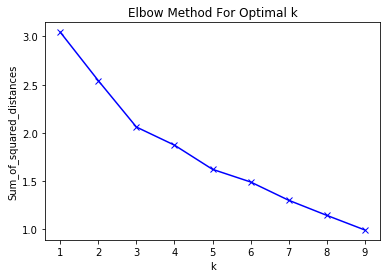

In [93]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

### Although I'm going to use 3 as the "elbow" the result above indicates that maybe the data is not very clustered or that an alternate method should have been used to find k (not part of week 3!!!)

### Set k to 3 as per the result from the graph above

In [94]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop(columns=['PostalCode'])

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int32)

### Add labels to dataframe

In [95]:
# add clustering labels
postalcode_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_main

# merge toronto_grouped with toronto_main to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(postalcode_venues_sorted.set_index('PostalCode'), on='PostalCode')

toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'] + 1
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Neighborhood,Boutique,Coffee Shop,Pub,Dog Run,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Pizza Place,Diner,Dessert Shop,Pub,Caribbean Restaurant
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,1,Sandwich Place,Italian Restaurant,Liquor Store,Sushi Restaurant,Brewery,Movie Theater,Pub,Ice Cream Shop,Light Rail Station,Steakhouse
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Park,Brewery,Seafood Restaurant,Sandwich Place
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1,Park,Lake,Dim Sum Restaurant,Swim School,Bus Line,Yoga Studio,Dumpling Restaurant,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant


## Map the clusters and analyze results

### From the results below we can see that cluster 1 (blue dots) is by far the biggest and that it contains a lot of the most popular venues. The chosen Toronto area is very homogeneous in regards to venues and we need to look hard to find the differences.

### Clusters 2 and 3 contain also contain some common venues such as the ubiquitous "Restaurants" but also some unique venues such as "playground" (cluster 2) and "home service" (cluster 3) that sets them apart.

In [96]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)

colors_array = cm.tab10(np.linspace(0, .5, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Borough'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1 (blue)

In [97]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,1,Neighborhood,Boutique,Coffee Shop,Pub,Dog Run,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
1,East Toronto,1,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Pizza Place,Diner,Dessert Shop,Pub,Caribbean Restaurant
2,East Toronto,1,Sandwich Place,Italian Restaurant,Liquor Store,Sushi Restaurant,Brewery,Movie Theater,Pub,Ice Cream Shop,Light Rail Station,Steakhouse
3,East Toronto,1,Café,Coffee Shop,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Park,Brewery,Seafood Restaurant,Sandwich Place
4,Central Toronto,1,Park,Lake,Dim Sum Restaurant,Swim School,Bus Line,Yoga Studio,Dumpling Restaurant,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant
5,Central Toronto,1,Restaurant,Breakfast Spot,Sandwich Place,Burger Joint,Food & Drink Shop,Hotel,Gym,Park,Falafel Restaurant,Event Space
6,Central Toronto,1,Sporting Goods Shop,Clothing Store,Coffee Shop,Yoga Studio,Sandwich Place,Salon / Barbershop,Chinese Restaurant,Pet Store,Park,Cosmetics Shop
7,Central Toronto,1,Sandwich Place,Dessert Shop,Coffee Shop,Italian Restaurant,Café,Thai Restaurant,Sushi Restaurant,Pizza Place,Pharmacy,Seafood Restaurant
9,Central Toronto,1,Convenience Store,Coffee Shop,Pub,American Restaurant,Sports Bar,Fried Chicken Joint,Bagel Shop,Supermarket,Sushi Restaurant,Pizza Place
11,Downtown Toronto,1,Coffee Shop,Restaurant,Pub,Pizza Place,Café,Italian Restaurant,Bakery,Market,Breakfast Spot,Chinese Restaurant


### Cluster 2 (green)

In [98]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Central Toronto,2,Trail,Playground,Gym,Ethiopian Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Yoga Studio
10,Downtown Toronto,2,Park,Playground,Trail,Yoga Studio,Dog Run,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space


### Cluster 3 (brown)

In [99]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,3,Home Service,Garden,Yoga Studio,Doner Restaurant,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
